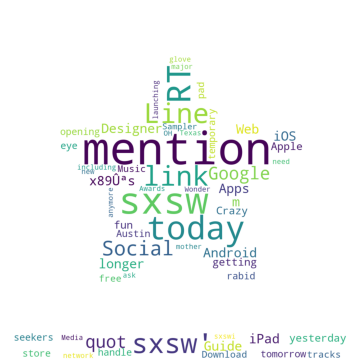

# Goals of this notebook are: 

* to identify the best models in terms of F1 score on the training and validation data for the **text** part of the data
* F1 was chosen, as the dataset at hand is imbalanced. 
* The following models will be evaluated: 
    * bag-of-words
    * a fully connected NN with "homegrown" embeddings layer
    * a fully connected NN with pre-trained embeddings layer
    * a "homegrown" embeddings layer with LSTM 
    * a pre-trained embeddings layer with LSTM
    * a "homegrown" embeddings layer with Conv1D 
    * a pre-trained embeddings layer with Conv1D
* to regularise the top 2 models in order for them to generalise better on unseen data
* to define the final model for the NLP part (see at the end)

# Import Libraries

In [1]:
import datetime
import itertools
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers
from keras import models
from keras import regularizers
from keras import utils
from keras.utils import to_categorical
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.models import save_model


%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

# Define Parameter Dictionary

In [3]:
logging = True

saving = True

PARAMS = {

    # Define experiment name:
    'experiment_name': 'all_models_regularisation',

    # List of models
    'model_type': ['bow', 'fc_emb', 'fc_transf', 'lstm', 'lstm_transf', 'conv1d', 'conv1d_transf'],

    # Parameters general:
    'number_of_classes': len(np.unique(train_descr['Sentiment'])),
    'n_splits': 4,
    'seed': 42,
    'batch_size': 32,
    'epochs': 15,
    'hidden_units': 32,

    # NLP Parameters
    # max_words = vocabulary size = our samples - number of most frequent words.
    # they are set to 10.000, although in this case there are less.
    # this is done to parametise the code.
    # aleternatively, it can be set to the length of our vocabulary = word_index
    'max_words': 10000,

    # embedding_size = embedding dimensionality
    'embedding_size': 30,

    # parameters for pre-trained word embeddings:
    'embedding_dim': 100,

    # parameters for the Conv1D:
    'conv_window': 5,

    # cross-fold validation:
    'k': 4,

    # regularisation types
    'reg_mode': ['l2', 'dropout', 'combi']
}

logdir = f'logs/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")
logdir_tb = f'logs/tensorboard/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")

# create logging folder and tensorboard callback function
if logging:
    print(f'Log results to {logdir}')
    if not os.path.exists(logdir):
        os.makedirs(logdir)

    tensorboard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir_tb)]

else:
    logdir = ''
    logdir_tb = ''
    tensorboard_callbacks = []

Log results to logs/experiments/all_models_regularisation_2020_12_19-20:39


# Load Tokens and Vocabulary

In [4]:
def load_data(path_to_corpus, one_hot=False):
    """
    Loads the tokenised text and produces the labels. 
    If one-hot encoded is not needed, the data is also padded. 

    Args: 
        - path_to_corpus - path to tokenised text
        - one_hot - if the model is bag-of-words, one-hot-encoded data is used. The default is False

    Returns:
        - sequences - tokenised text
        - word_index - a dictionary having as key the word and as value its index
        - data - in case of one_hot=False the padded sequences
        - labels - the sentiments 
    """

    sequences, word_index = pd.read_pickle(path_to_corpus)

    if not one_hot:
        # max_len = sequence length - the text is cut off after this number of words
        # in this case it is defined as the maximum sequence length in our list of tokenised sequences
        max_len = np.max([len(x) for x in sequences])
        data = tf.keras.preprocessing.sequence.pad_sequences(
            sequences, maxlen=max_len)
    else:
        data = sequences

    labels = train_descr.loc[:, 'Sentiment'].to_list()

    return sequences, word_index, data, labels

### For bag-of-words with one-hot encoded tokens

In [5]:
sequences_oh, word_index_oh, data_oh, labels_oh = load_data(
    preprocessed_corpus_path_TF_oh, one_hot=True)
sequences_oh.shape

(6364, 10000)

### For the models with embedding layer

In [6]:
sequences, word_index, data, labels = load_data(preprocessed_corpus_path_TF)
print(f'Shape of sequences after padding is {data.shape}')

Shape of sequences after padding is (6364, 25)


### Add max_len to parameters dictionary

In [7]:
max_len = np.max([len(x) for x in sequences])
PARAMS['max_len'] = max_len

# Preparation for the Pre-Trained Embeddings

In [8]:
glove_dir = './glove.6B'

In [9]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_matrix = np.zeros((PARAMS['max_words']+1, PARAMS['embedding_dim']))

for word, i in word_index.items():
    if i < PARAMS['max_words']:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


# Train-Test Split

In [11]:
def train_test_split(data, labels):
    """
    Splits the data into train and test data sets.
    One-hot encodes the labels.

    Args: 
        - data - preprocessed text_data
        - labels - sentiments

    Returns: 
        - x_train, y_train_oh - training text data & the corresponding one-hot encoded labels
        - x_test, y_test_oh - test text data & the corresponding one-hot encoded labels
    """
    dimensions_labels = PARAMS['number_of_classes']

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = np.asarray(labels)
    labels = labels[indices]

    training_samples = int(0.8 * len(data))

    x_train = data[:training_samples]
    y_train = labels[:training_samples]

    x_test = data[training_samples:]
    y_test = labels[training_samples:]

    y_train_oh = tf.one_hot(indices=y_train, depth=dimensions_labels)
    y_train_oh = np.asarray(y_train_oh)

    y_test_oh = tf.one_hot(indices=y_test, depth=dimensions_labels)
    y_test_oh = np.asarray(y_test_oh)

    return x_train, y_train_oh, x_test, y_test_oh

In [12]:
x_train, y_train, x_test, y_test = train_test_split(data, labels)

x_train_oh, y_train_oh, x_test_oh, y_test_oh = train_test_split(
    data_oh, labels_oh)

# Preparation for Model Generation & Training

### Function for Oversampling the Minority Classes

SMOTE = Synthetic Minority Oversampling Technique. It was chosen, because the data set is small and oversampling will, even if synthetically, increase it.

In [13]:
def oversample_smote(x_train, y_train):
    """
    This function produces an oversampled set of train data using SMOTE

    Args: 
        - x_train - imbalanced train features (= text descriptions)
        - y_train - imbalanced train labels (= sentiments)

    Returns: 
        - x_train - oversampled train features (= text descriptions)
        - y_train - oversampled train labels (= sentiments)

    """
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    return x_train, y_train

### Function to Generate the Models

In [14]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [15]:
def generate_model(model_type, params_dict):
    """
    This function compiles a model according to the chosen model_type
    Args: 
        - model_type - which model type is to be used
        - params_dict - dictionary with parameters for the model

    Returns: 
        - a compiled model
    """

    # set parameters
    hidden_units = params_dict['hidden_units']
    dimensions_labels = params_dict['number_of_classes']
    max_words = params_dict['max_words']
    max_len = params_dict['max_len']
    embedding_size = params_dict['embedding_size']
    embedding_dim = params_dict['embedding_dim']
    conv_window = params_dict['conv_window']

    # fully connected bag-of-words
    if model_type == params_dict['model_type'][0]:
        model = models.Sequential()
        model.add(layers.Dense(hidden_units, activation='relu',
                               input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & "homegrown" embeddings layer
    elif model_type == params_dict['model_type'][1]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & a pre-trained embeddings layer
    elif model_type == params_dict['model_type'][2]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    # lstm with "homegrowm" embeddings layer
    elif model_type == params_dict['model_type'][3]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # lstm with pre-trained embeddings layer
    elif model_type == params_dict['model_type'][4]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights(
            [embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    # conv1D with "homegrown" embeddings layer
    elif model_type == params_dict['model_type'][5]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))

        model.add(layers.Conv1D(
            hidden_units,  # features to be extracted
            conv_window,  # convolutional window size
            activation='relu',
        ))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # conv1D with pre-trained embeddings layer
    elif model_type == params_dict['model_type'][6]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))

        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu',))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

### Function for Training with Cross-Validation (incl. Upsampling)

* Due to the small data quantity, cross-validation will be used to train the models.
* Furthermore, as the classes are imbalanced, an oversampling will be introduced. ! It is important to generate the training and validation sets BEFORE the upsampling. Otherwise the exact same observations could be present in both the train and validation sets, i.e. data leakage would occur. This can allow the model to simply memorize specific data points and cause overfitting and poor generalization on unseen data. 
* The oversampling will be applied only on the train set in order to ensure that the model generalises well on unseen data (validation set and ultimately test set)

In [16]:
def train_with_cross_val(k, model, model_type, train_data, train_labels, epochs, batch_size, reg_mode=None, reg=False):
    """
    This function applies a k-fold cross-validation and saves the model history per fold, epoch and if 
    given per regularisation type.

    Args: 
        - k - number of folds
        - model - compiled model
        - model_type - which model type is to be used
        - train_data - the tokenised, padded and shuffled sequences
        - train_labels - labels 
        - epochs - number of epochs
        - batch_size - batch size
        - reg_mode - which type of regularisaion is used, if any
        - reg - is regularisation applied
    """
    num_val_samples = len(train_data) // k

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_labels = train_labels[i *
                                  num_val_samples:(i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_labels = np.concatenate(
            [train_labels[:i * num_val_samples],
             train_labels[(i + 1) * num_val_samples:]],
            axis=0
        )

        partial_train_data_ovs, partial_train_labels_ovs = oversample_smote(
            partial_train_data, partial_train_labels)

        history = model.fit(
            partial_train_data_ovs, partial_train_labels_ovs,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(val_data, val_labels),
            # callbacks=tensorboard_callbacks
        )

        if not reg:
            np.save(f'history_{model_type}_fold_{i}.npy', history.history)

        else:
            np.save(
                f'history_{model_type}_{reg_mode}_fold_{i}.npy', history.history)

    if saving:
        if not reg:
            path = os.path.join(logdir, f'{model_type}')
            model.save(path)
        else:
            path = os.path.join(logdir, f'{model_type}_{reg_mode}')
            model.save(path)

### Create the Baseline Model for Comparison

Idea Model: https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


* As the Fully Connected NN model's the precision, recall and f1 are calculcated unweighted, precision, recall & f1 are chosen to be macro
* According to the sklearn-documentation this method calculates the metrics for each label, and finds their unweighted mean and does not take label imbalance into account.
* Example documentation for precision: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

Note: test_[metric] is validation and therefore comparable to the val_[metric] of the model.

In [17]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [18]:
model_base = DummyClassifier(strategy='most_frequent')

In [19]:
cv = KFold(n_splits=PARAMS['k'], random_state=PARAMS['seed'])

scores = cross_validate(
    model_base, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [20]:
for metric, score in scores.items():
    print(f'Mean {metric}: %.3f (%.3f)' %
          (np.mean(score), np.std(score)))

Mean fit_time: 0.001 (0.000)
Mean score_time: 0.015 (0.001)
Mean test_accuracy: 0.592 (0.020)
Mean test_precision_macro: 0.148 (0.005)
Mean test_recall_macro: 0.250 (0.000)
Mean test_f1_macro: 0.186 (0.004)


# Train the Model per Type

In [ ]:
for model_type in PARAMS['model_type']:
    model = generate_model(model_type, PARAMS)

    if model_type == PARAMS['model_type'][0]:
        train_with_cross_val(PARAMS['k'], model, model_type, x_train_oh,
                             y_train_oh, PARAMS['epochs'], PARAMS['batch_size'])
    else:
        train_with_cross_val(
            PARAMS['k'], model, model_type, x_train, y_train, PARAMS['epochs'], PARAMS['batch_size'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 321,220
Trainable params: 321,220
Non-trainable params: 0
_________________________________________________________________
processing fold # 0


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: logs/experiments/all_models_regularisation_2020_12_19-20:39/bow/assets
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 30)            300030    
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                24032     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
____________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_regularisation_2020_12_19-20:39/fc_emb/assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 1,081,320
Trainable params: 81,220
Non-trainable params: 1,000,100
______________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_regularisation_2020_12_19-20:39/fc_transf/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
Total params: 1,019,368
Trainable params: 1,019,368
Non-trainable params: 0
________________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_regularisation_2020_12_19-20:39/lstm/assets
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
Total params: 1,019,368
Trainable params: 19,268
Non-trainable params: 1,000,100
________________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# Evaluate the Models

### Generate a Metrics Dataframe

In [ ]:
history_all_df = pd.DataFrame()

for model_type in PARAMS['model_type']:
    for i in range(PARAMS['k']):
        history = np.load(
            f'history_{model_type}_fold_{i}.npy', allow_pickle='TRUE').item()
        history['model_type'] = model_type

        history_df = pd.DataFrame(history)

        history_df['f1'] = 2 * history_df.precision * \
            history_df.recall/(history_df.precision + history_df.recall)
        history_df['f1'] = history_df['f1'].fillna(0)
        history_df['val_f1'] = 2 * history_df.val_precision * \
            history_df.val_recall / \
            (history_df.val_precision + history_df.val_recall)
        history_df['val_f1'] = history_df['val_f1'].fillna(0)

        history_all_df = history_all_df.append(history_df)

history_all_df
history_all_df_pivot = history_all_df.pivot_table(columns=['model_type'],
                                                  values=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'f1', 'val_f1'])

In [ ]:
history_all_df

In [ ]:
history_all_df_pivot

### Pick the 2 models with the highest F1-score

* All of the models outperform the baseline model in all the metrics
* The models before regularisation with the best F1-score are the bag-of-words and the "homegrown" embeddings
* These two models will be optimised further and the best performing one (see regularisation section) will be used for the final multi-input model

In [ ]:
history_all_df_pivot.idxmax(axis=1)

In [ ]:
history_all_df_pivot.loc['val_f1', ].max()

### Generate Summary Figures

In [ ]:
history_all_grouped = history_all_df.groupby('model_type').mean()
history_all_grouped = history_all_grouped.reset_index()
history_all_grouped

### Function for Plotting Train vs. Validation Metrics

In [ ]:
def plot_train_vs_validation(models_list, history_df, params, reg=False):
    '''
    Function to plot a training metric vs. a validation one 

    Args:
        - models_list - models, for which the results will be visualised 
        - history_df - dataframe with results from model training
        - params - parameters dictionary
        - reg - if there was regularisation or not
    '''

    epochs = params['epochs']
    epochs_graph = range(1, params['epochs'] + 1)
    folds = params['k']

    if not reg:
        for model_type in models_list:
            fig = plt.figure(figsize=(15, 5))
            ax = plt.subplot(131)

            epochs = params['epochs']
            epochs_graph = range(1, params['epochs'] + 1)
            folds = params['k']

            mask = history_df.loc[:, 'model_type'] == model_type

            loss_all = history_df.loc[mask, 'loss'].to_list()
            loss_prep = [loss_all[i * epochs:(i + 1) * epochs]
                         for i in range(folds)]
            loss = [np.mean([x[i] for x in loss_prep]) for i in range(epochs)]

            val_loss_all = history_df.loc[mask, 'val_loss'].to_list()
            val_loss_prep = [
                val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
            val_loss = [np.mean([x[i] for x in val_loss_prep])
                        for i in range(epochs)]

            accuracy_all = history_df.loc[mask, 'accuracy'].to_list()
            accuracy_prep = [
                accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
            accuracy = [np.mean([x[i] for x in accuracy_prep])
                        for i in range(epochs)]

            val_accuracy_all = history_df.loc[mask, 'val_accuracy'].to_list()
            val_accuracy_prep = [val_accuracy_all[i *
                                                  epochs:(i + 1) * epochs] for i in range(folds)]
            val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                            for i in range(epochs)]

            f1_all = history_df.loc[mask, 'f1'].to_list()
            f1_prep = [f1_all[i * epochs:(i + 1) * epochs]
                       for i in range(folds)]
            f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

            val_f1_all = history_df.loc[mask, 'val_f1'].to_list()
            val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
                           for i in range(folds)]
            val_f1 = [np.mean([x[i] for x in val_f1_prep])
                      for i in range(epochs)]

            plt.plot(epochs_graph, loss, 'b')
            plt.plot(epochs_graph, val_loss, 'r')
            plt.ylim([0, 2])
            ax.set_ylabel('loss')
            ax.set_xlabel('epochs')
            ax.legend(['train', 'validation'])
            plt.title(f'Train vs. Validation Loss {model_type}')

            ax = plt.subplot(132)
            plt.plot(epochs_graph, accuracy, 'b')
            plt.plot(epochs_graph, val_accuracy, 'r')
            plt.ylim([0, 1])
            ax.set_ylabel('accuracy')
            ax.set_xlabel('epochs')
            ax.legend(['train', 'validation'])
            plt.title(f'Train vs. Validation Accuracy {model_type}')

            ax = plt.subplot(133)
            plt.plot(epochs_graph, f1, 'b')
            plt.plot(epochs_graph, val_f1, 'r')
            plt.ylim([0, 1])
            ax.set_ylabel('f1')
            ax.set_xlabel('epochs')
            ax.legend(['train', 'validation'])
            plt.title(f'Train vs. Validation F1-Score {model_type}')

            plt.show()

            if logging:
                if not os.path.exists(os.path.join(logdir, 'figures')):
                    os.makedirs(os.path.join(logdir, 'figures'))
                fig.savefig(os.path.join(
                    logdir, f'figures/loss_accuracy_training_{model_type}.png'), bbox_inches='tight')

    else:
        for model_type in models_list:
            for reg_mode in PARAMS['reg_mode']:
                mask = (history_df.loc[:, 'model_type'] == model_type) & (
                    history_df.loc[:, 'reg_mode'] == reg_mode)

                loss_all = history_df.loc[mask, 'loss'].to_list()
                loss_prep = [loss_all[i * epochs:(i + 1) * epochs]
                             for i in range(folds)]
                loss = [np.mean([x[i] for x in loss_prep])
                        for i in range(epochs)]

                val_loss_all = history_df.loc[mask, 'val_loss'].to_list()
                val_loss_prep = [
                    val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
                val_loss = [np.mean([x[i] for x in val_loss_prep])
                            for i in range(epochs)]

                accuracy_all = history_df.loc[mask, 'accuracy'].to_list()
                accuracy_prep = [
                    accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
                accuracy = [np.mean([x[i] for x in accuracy_prep])
                            for i in range(epochs)]

                val_accuracy_all = history_df.loc[mask, 'val_accuracy'].to_list(
                )
                val_accuracy_prep = [val_accuracy_all[i *
                                                      epochs:(i + 1) * epochs] for i in range(folds)]
                val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                                for i in range(epochs)]

                f1_all = history_df.loc[mask, 'f1'].to_list()
                f1_prep = [f1_all[i * epochs:(i + 1) * epochs]
                           for i in range(folds)]
                f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

                val_f1_all = history_df.loc[mask, 'val_f1'].to_list()
                val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
                               for i in range(folds)]
                val_f1 = [np.mean([x[i] for x in val_f1_prep])
                          for i in range(epochs)]

                fig = plt.figure(figsize=(15, 5))

                ax = plt.subplot(131)
                plt.plot(epochs_graph, loss, 'b')
                plt.plot(epochs_graph, val_loss, 'r')
                plt.ylim([0, 2])
                ax.set_ylabel('loss')
                ax.set_xlabel('epochs')
                ax.legend(['train', 'validation'])
                plt.title(f'Train vs. Validation Loss {model_type} {reg_mode}')

                ax = plt.subplot(132)
                plt.plot(epochs_graph, accuracy, 'b')
                plt.plot(epochs_graph, val_accuracy, 'r')
                plt.ylim([0, 1])
                ax.set_ylabel('accuracy')
                ax.set_xlabel('epochs')
                ax.legend(['train', 'validation'])
                plt.title(
                    f'Train vs. Validation Accuracy {model_type} {reg_mode}')

                ax = plt.subplot(133)
                plt.plot(epochs_graph, f1, 'b')
                plt.plot(epochs_graph, val_f1, 'r')
                plt.ylim([0, 1])
                ax.set_ylabel('f1')
                ax.set_xlabel('epochs')
                ax.legend(['train', 'validation'])
                plt.title(
                    f'Train vs. Validation F1-Score {model_type} {reg_mode}')

                plt.show()

                if logging:
                    if not os.path.exists(os.path.join(logdir, 'figures')):
                        os.makedirs(os.path.join(logdir, 'figures'))
                    fig.savefig(os.path.join(
                        logdir, f'figures/loss_accuracy_training_{model_type}_{reg_mode}.png'), bbox_inches='tight')

In [ ]:
plot_train_vs_validation(PARAMS['model_type'], history_all_df, PARAMS)

# Regularization

* Two models were found, which have very good performance on the training data, i.e. they are very well optimised: bag-of-words (=bow) and "homegrown" embeddings (=fc_emb)
* With this the goal to find the best performance on the training data was achieved. 
* However, as a result they overfit, i.e. they do not perform well on data they have never seen before. The wide gap between loss vs. validation loss on the graphs above is an indicator of this. 
* Now, the models should be adjusted to perform well also on unseen data, i.e. to generalise better. 
* Several possibilites to do that - more data and / or modulate the quantity of information that the model is allowed to store or to add constraints on what information it’s allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.
* The latter is called regularisation and this is what will be applied, as currently there is no additional data available. 
* Regularisation can be achieved by reducing the capacity of the model, adding weight regularisation or introducing dropout
* As both models are not that complex, their capacity will not be reduced
* Weights regularisation, Dropout & their combination will be tested

### Weight Regularisation

**Explanation of regularisation as given in "Deep Learning with Python" by Chollet, p.130:** "You may be familiar with the principle of Occam’s razor: given two explanations for something, the explanation most likely to be correct is the simplest one - the one that makes fewer assumptions. This idea also applies to the models learned by neural networks: given some training data and a network architecture, multiple sets of weight values (multiple models) could explain the data. Simpler models are less likely to overfit than complex ones.
A simple model in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as you saw in the previous section). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to take only small values, which makes the distribution of weight values more regular. This is called weight regularization, and it’s done by adding to the loss function of the network a cost associated with having large weights. "

### Dropout

**Explanation of dropout as given in "Deep Learning with Python" by Chollet, p.132:** "...Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training. Let’s say a given layer would normally return a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training. After applying dropout, this vector will have a few zero entries distributed at random: for example, [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time. 

...was inspired by, among other things, a fraud-prevention mecha- nism used by banks. In his own words, “I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting.” The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant (what Hinton refers to as conspiracies), which the network will start memorizing if no noise is present.
"

In [ ]:
def generate_model_reg(model_type, params_dict, reg_mode):
    """
    This function compiles a model according to the chosen model_type
    Args: 
        - model_type - which model type is to be used
        - params_dict - dictionary with parameters for the model
        - reg_mode - regularisation type applied

    Returns: 
        - a compiled model
    """

    # set parameters
    hidden_units = params_dict['hidden_units']
    dimensions_labels = params_dict['number_of_classes']
    max_words = params_dict['max_words']
    max_len = params_dict['max_len']
    embedding_size = params_dict['embedding_size']
    embedding_dim = params_dict['embedding_dim']
    conv_window = params_dict['conv_window']

    if reg_mode == 'l2':
        # every coefficient in the weight matrix of the layer will add regularisation factor * weight_coefficient_value
        # to the total loss of the network
        # the default value for the regularisation factor is 0.01
        # Keras documentation: https://keras.io/api/layers/regularizers/

        # fully connected bag-of-words
        if model_type == params_dict['model_type'][0]:
            model = models.Sequential()
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu',
                                   input_shape=(max_words, )))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

        # fully connected & "homegrown" embeddings layer
        elif model_type == params_dict['model_type'][1]:
            model = models.Sequential()
            model.add(layers.Embedding(max_words+1,
                                       embedding_size, input_length=max_len))
            model.add(layers.Flatten())
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

    elif reg_mode == 'dropout':
        # rate: what percentage of the input units to drop
        # Keras documentation: https://keras.io/api/layers/regularization_layers/dropout/

        # fully connected bag-of-words
        if model_type == params_dict['model_type'][0]:
            model = models.Sequential()
            model.add(layers.Dense(hidden_units, activation='relu',
                                   input_shape=(max_words, )))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units, activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

        # fully connected & "homegrown" embeddings layer
        elif model_type == params_dict['model_type'][1]:
            model = models.Sequential()
            model.add(layers.Embedding(max_words+1,
                                       embedding_size, input_length=max_len))
            model.add(layers.Flatten())
            model.add(layers.Dense(hidden_units, activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units, activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

    elif reg_mode == 'combi':
        # fully connected bag-of-words
        if model_type == params_dict['model_type'][0]:
            model = models.Sequential()
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu',
                                   input_shape=(max_words, )))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

        # fully connected & "homegrown" embeddings layer
        elif model_type == params_dict['model_type'][1]:
            model = models.Sequential()
            model.add(layers.Embedding(max_words+1,
                                       embedding_size, input_length=max_len))
            model.add(layers.Flatten())
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

In [ ]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        model = generate_model_reg(model_type, PARAMS, reg_mode)

        if model_type == PARAMS['model_type'][0]:
            train_with_cross_val(PARAMS['k'], model, model_type, x_train_oh,
                                 y_train_oh, PARAMS['epochs'], PARAMS['batch_size'], reg_mode, reg=True)
        else:
            train_with_cross_val(
                PARAMS['k'], model, model_type, x_train, y_train, PARAMS['epochs'], PARAMS['batch_size'], reg_mode, reg=True)

In [ ]:
history_all_df_reg = pd.DataFrame()

for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        for i in range(PARAMS['k']):
            history = np.load(
                f'history_{model_type}_{reg_mode}_fold_{i}.npy', allow_pickle='TRUE').item()
            history['model_type'] = model_type
            history['reg_mode'] = reg_mode

            history_df_reg = pd.DataFrame(history)

            history_df_reg['f1'] = 2 * history_df.precision * \
                history_df.recall / \
                (history_df_reg.precision + history_df_reg.recall)
            history_df_reg['f1'] = history_df_reg['f1'].fillna(0)
            history_df_reg['val_f1'] = 2 * history_df_reg.val_precision * \
                history_df_reg.val_recall / \
                (history_df_reg.val_precision + history_df_reg.val_recall)
            history_df_reg['val_f1'] = history_df_reg['val_f1'].fillna(0)

            history_all_df_reg = history_all_df_reg.append(history_df_reg)

history_all_df_reg
history_all_df_pivot_reg = history_all_df_reg.pivot_table(columns=['model_type', 'reg_mode'],
                                                          values=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'f1', 'val_f1'])

In [ ]:
history_all_df_pivot_reg

In [ ]:
choice_of_regularised_models = PARAMS['model_type'][:2]

In [ ]:
plot_train_vs_validation(choice_of_regularised_models,
                         history_all_df_reg, PARAMS, reg=True)

# Compare the No Regularised Models to the Regularised Ones to Determine the Optimal One

inspired by: https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e

In [ ]:
def compare_models_by_metric(model_type, reg_mode, history_all_df, history_all_df_reg, metric_train, metric_val, params):
    '''
    Function that plots a training and a validation metric for a non-regularised and regularised model 

    Args:
        - model_type - model used
        - reg_mode - regularisation mode used - l2, dropout, combination of the two
        - history_all_df - dataframe with results from models without regularisation
        - history_all_df_reg - dataframe with results from models with regularisation
        - metric_train - training metric to compare
        - metric_val - validation metric to compare
        - params - parameters dictionary
    '''

    epochs = params['epochs']
    epochs_graph = range(1, params['epochs'] + 1)
    folds = params['k']

    mask_base = (history_all_df.loc[:, 'model_type'] == model_type)
    mask_reg = (history_all_df_reg.loc[:, 'model_type'] == model_type) & (
        history_all_df_reg.loc[:, 'reg_mode'] == reg_mode)

    # metric train base model
    metric_train_all_base = history_all_df.loc[mask_base, metric_train].to_list(
    )
    metric_train_prep_base = [
        metric_train_all_base[i * epochs:(i + 1) * epochs] for i in range(folds)]
    metric_train_base = [np.mean([x[i] for x in metric_train_prep_base])
                         for i in range(epochs)]

    # metric train regularised model
    metric_train_all_reg = history_all_df_reg.loc[mask_reg, metric_train].to_list(
    )
    metric_train_prep_reg = [
        metric_train_all_reg[i * epochs:(i + 1) * epochs] for i in range(folds)]
    metric_train_reg = [np.mean([x[i] for x in metric_train_prep_reg])
                        for i in range(epochs)]

    # metric validation base model
    metric_val_all_base = history_all_df.loc[mask_base, metric_val].to_list()
    metric_val_prep_base = [
        metric_val_all_base[i * epochs:(i + 1) * epochs] for i in range(folds)]
    metric_val_base = [np.mean([x[i] for x in metric_val_prep_base])
                       for i in range(epochs)]

    # metric validation regularised model
    metric_val_all_reg = history_all_df_reg.loc[mask_reg, metric_val].to_list()
    metric_val_prep_reg = [
        metric_val_all_reg[i * epochs:(i + 1) * epochs] for i in range(folds)]
    metric_val_reg = [np.mean([x[i] for x in metric_val_prep_reg])
                      for i in range(epochs)]

    metrics_dict = {
        'loss': 'Training Loss',
        'acc': 'Training Accuracy',
        'precision': 'Training Precision',
        'recall': 'Training Recall',
        'f1': 'Training F1',
        'val_loss': 'Validation Loss',
        'val_acc': 'Validation Accuracy',
        'val_precision': 'Validation Precision',
        'val_recall': 'Validation Recall',
        'val_f1': 'Validation F1'
    }

    metric_train_label = metrics_dict[metric_train]
    metric_val_label = metrics_dict[metric_val]

    fig = plt.figure(figsize=(5, 5))

    plt.plot(epochs_graph, metric_train_base, 'b',
             label=f'{model_type} No Regularisation Training Loss')
    plt.plot(epochs_graph, metric_train_reg, 'bo',
             label=f'{model_type} {reg_mode} Regularisation Training Loss')
    plt.plot(epochs_graph, metric_val_base, 'r',
             label=f'{model_type} No Regularisation Validation Loss')
    plt.plot(epochs_graph, metric_val_reg, 'ro',
             label=f'{model_type} {reg_mode} Regularisation Validation Loss')
    plt.xlabel('Epoch number')
    plt.ylabel(f'{metric_train_label}, {metric_val_label}')
    plt.ylim([0, 2])
    plt.title(
        f'Comparing {metric_train_label} & {metric_val_label}es - base vs. {reg_mode} {model_type} model')
    plt.legend()
    plt.show()

    if logging:
        if not os.path.exists(os.path.join(logdir, 'figures')):
            os.makedirs(os.path.join(logdir, 'figures'))
        fig.savefig(os.path.join(
            logdir, f'figures/compare_base_vs_regularised_model_{model_type}_{reg_mode}.png'), bbox_inches='tight')

The graphs below help to analyse 3 things pointing to a successful reduction of the overfitting: 
* narrower gap between training and validataion loss
* does the regularised model overfit "later" than the baseline one, i.e. it takes more epochs before train & validation loss go apart.
* does the validation loss of the regularised model goes up slower than the one of the baseline

Results for **l2**:
- for the bow model - the gap seems about the same. The overfitting starts at the same time as the baseline model. However, the validation loss increases slower afterward. 
- the regularised "homegrown"-embedding model exhibits also about the same gap as compared to the baseline model and a shift in the epoch when the overfitting starts. At the same time there is a slightly smoother progress of the regularised validation loss.


Results for **dropout**:
- bow - narrower gap; light shift in the epoch; smoother validation loss development
- "homegrown"-embedding model - wider gap; shift in the epoch, steeper regularised validation loss


Results for **combi** = l2 & dropout:
- bow - narrower gap; no shift; smoother validation loss progress
- "homegrown"-embedding model - narrower gap; significant shift; significantly smoother development of the regularised validation loss 

### Conclusion: 

Based on the results above the bow model with dropout performs the best - least overfitting (narrowest gap between training and validation loss), lowest loss of all regularised models and smooth regularised validation loss development. 

The second best model is the "homegrown"-embedding one, as the overfitting is significantly reduced and the regularised validation loss is stable. 

The final decision which model to use will be made based on: 
- F1 metric and 
- the performance on the test data

In [ ]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        compare_models_by_metric(
            model_type, reg_mode, history_all_df, history_all_df_reg, 'loss', 'val_loss', PARAMS)

### Check Validation F1-Score

Here bag-of-words with dropout is again the best one

In [ ]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        mask_model_reg = (history_all_df_reg.loc[:, 'model_type'] == model_type) & (
            history_all_df_reg.loc[:, 'reg_mode'] == reg_mode)
        f1_model_reg = np.mean(
            history_all_df_reg.loc[mask_model_reg, 'val_f1'])
        print(
            f'{model_type} with {reg_mode} regularisation has F1 score of {f1_model_reg:.2f}')

### Final Evaluation of Models on Test Data

The bag-of-words with dropout is again the best model when it comes to F1. However, the loss is quite high. The model with both l2 and dropout has a F1 score only slightly lower than the model only with dropout, but has a much lower loss. Therefore, the former will be selected as the final model. It is the best model to generalise. 

Below I also offer a few thoughts what were my expectations at the beginning and why the data proved otherwise: 

* my expectations were that a model with pre-trained embeddings in combination with an LSTM or Conv1D will outperform the rest. 
* My reasoning was that the pre-trained embeddings will enforce the generalisation while an LSTM or Conv1D will help capture the text sequence. 

However, it turned out: 
* that "homegrown" embeddings are better than pre-trained. This can be explained by the small amount of data and the tech concentrated nature of the text descriptions. These "specificities" were better captured by training the data's own embeddings (that is why also "homegrown"). 
* that bag-of-words is better than any model with embeddings. This for me was the biggest surprise. After a discussion with a mentor of mine an explanation can be that due to the short length of the text descriptions and relatively "loose" way of writing them, semantics and text structure do not play a significant role. Much more important is, if a word is present, which is what bag-of-words captures. 

In [ ]:
def test_model(model_type, reg_mode, x_test, y_test):
    """
    Function that loads the saved trained models and evaluates on the test data

    Args: 
        - model_type - model to be used
        - reg_mode - regulasation applied
        - x_test - test features (= descriptions)
        - y_test - test labels (= sentiments)

    Returns: 
        - results - loss, accuracy, recall, precision
        - f1_score  
    """

    model_path = os.path.join(logdir, f'{model_type}_{reg_mode}')
    model = tf.keras.models.load_model(model_path)
    results = model.evaluate(x_test, y_test)
    precision = results[1]
    recall = results[2]
    f1_score = 2 * precision * recall / (precision + recall)
    print()
    print(f'Test f1-score for {model_type} with {reg_mode}: {f1_score}')
    return results, f1_score

In [ ]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        if model_type == 'bow':
            results, f1_score = test_model(
                model_type, reg_mode, x_test_oh, y_test_oh)
        else:
            results, f1_score = test_model(
                model_type, reg_mode, x_test, y_test)

### Confusion Matrix

Let's also take a look at the confusion matrix in order to see how the models perform on the different classes. 

The matrixes confirm the results from the evaluation on the test data - the best model is now bag-of-words with both l2 and dropout. Compared to the other models it performs (relatively) well among all classes (= the sentiments) in terms of accuracy. 

Source: https://github.com/javaidnabi31/Multi-class-with-imbalanced-dataset-classification/blob/master/20-news-group-classification.ipynb

In [ ]:
def plot_confusion_matrix(cm, classes, params,
                          normalise=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Args: 
        - cm - confusion matrix as generated by sklearns confusion_matrix
        - classes - labels (=sentiments)
        - normalise - normalisation can be applied by setting `normalise=True`
        - title of the plot
        - cmap - colors of the label squares
    """
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    number_of_classes = params['number_of_classes']

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(number_of_classes)
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classes = train_descr.loc[:, 'Sentiment'].unique()
classes = classes.sort()

for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        model_path = os.path.join(logdir, f'{model_type}_{reg_mode}')
        model = tf.keras.models.load_model(model_path)

        if model_type == 'bow':
            y_pred = model.predict(x_test_oh)
            cnf_matrix = confusion_matrix(
                np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1))

            # Plot normalised confusion matrix
            fig = plt.figure()
            fig.set_size_inches(7, 6, forward=True)

            plot_confusion_matrix(cnf_matrix, classes, PARAMS, normalise=True,
                                  title=f'Normalised confusion matrix of model {model_type} with {reg_mode}')
        else:
            y_pred = model.predict(x_test)
            cnf_matrix = confusion_matrix(
                np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

            # Plot confusion matrix
            fig = plt.figure()
            fig.set_size_inches(7, 6, forward=True)

            plot_confusion_matrix(cnf_matrix, classes, PARAMS, normalise=True,
                                  title=f'Normalised confusion matrix of model {model_type} with {reg_mode}')

In [ ]:
for model_type in PARAMS['model_type']:
    model_path = os.path.join(logdir, f'{model_type}')
    model = tf.keras.models.load_model(model_path)

    if model_type == 'bow':
        y_pred = model.predict(x_test_oh)
        cnf_matrix = confusion_matrix(
            np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1))

        # Plot normalised confusion matrix
        fig = plt.figure()
        fig.set_size_inches(7, 6, forward=True)

        plot_confusion_matrix(cnf_matrix, classes, PARAMS, normalise=False,
                              title=f'Normalised confusion matrix of model {model_type}')
    else:
        y_pred = model.predict(x_test)
        cnf_matrix = confusion_matrix(
            np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

        # Plot confusion matrix
        fig = plt.figure()
        fig.set_size_inches(7, 6, forward=True)

        plot_confusion_matrix(cnf_matrix, classes, PARAMS, normalise=False,
                              title=f'Normalised confusion matrix of model {model_type}')

# On the Side: Defining the Epoch with the Lowest Validation Loss

In [ ]:
def optimal_epoch(history_df, model_type, reg=False, reg_mode=None):
    """
    Function to return the epoch number where the validation loss is
    at its minimum

    Args:
        history_df - dataframe with training & validation history of model
        model_type - which model
        reg - is regularisation applied (default value is False)
        reg_mode - if reg==True, which regularisation was applied
    Returns:
        epoch number with minimum validation loss
    """

    if not reg:
        mask = history_df.loc[:, 'model_type'] == model_type
        min_epoch = np.argmin(history_df.loc[mask, 'val_loss'])
        print(
            f'Minimum validation loss for {model_type} reached in epoch {min_epoch}')

    else:
        mask = (history_df.loc[:, 'model_type'] == model_type) & (
            history_df.loc[:, 'reg_mode'] == reg_mode)
        min_epoch = np.argmin(history_df.loc[mask, 'val_loss'])
        print(
            f'Minimum validation loss for {model_type} and reg mode {reg_mode} reached in epoch {min_epoch}')

    return min_epoch

In [ ]:
for model_type in PARAMS['model_type']:
    optimal_epoch(history_all_df, model_type)

In [ ]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        optimal_epoch(history_all_df_reg, model_type,
                      reg=True, reg_mode=reg_mode)